In [10]:
%pip install requests

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import requests
import time


Note: you may need to restart the kernel to use updated packages.


/var/folders/qw/l_8mqcwx11s020m7gp2bhhzr0000gn/T/ipykernel_61330/2067053083.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gwas_data = pd.read_csv(gwas_file, delim_whitespace=True)


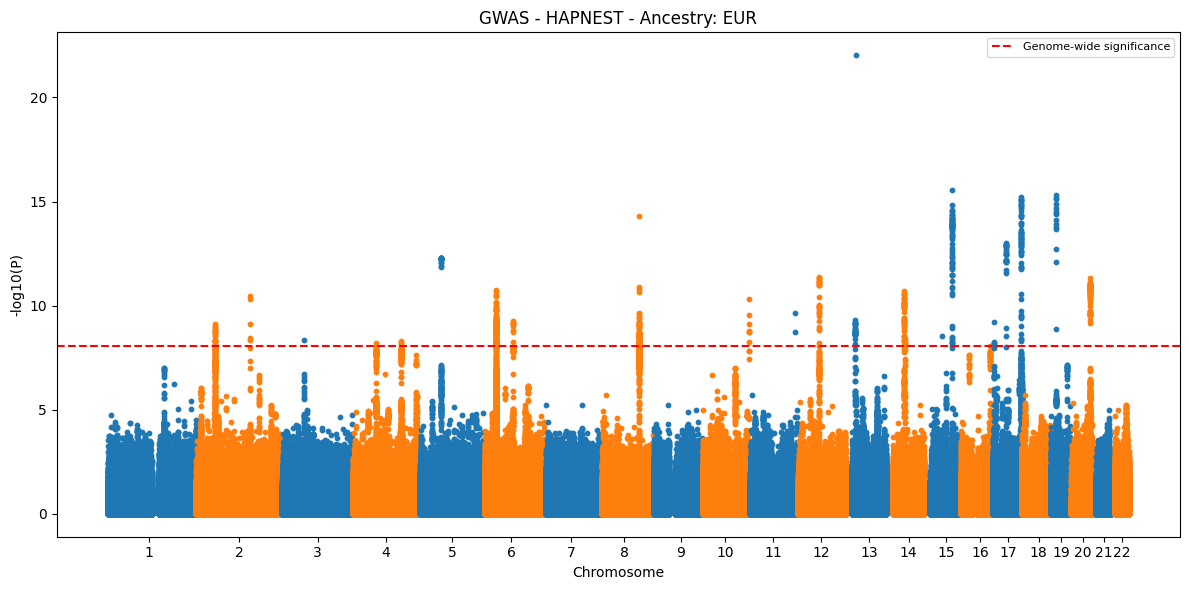

In [ ]:
# === LOAD DATA ===
# Lade die GWAS-Ergebnisse
gwas_file = "../data/processed/AFR/synthetic_v1_GWAS_logistic.assoc.logistic"
gwas_data = pd.read_csv(gwas_file, delim_whitespace=True)

# Entferne Zeilen mit fehlenden P-Werten
gwas_data = gwas_data.dropna(subset=["P"])
num_tests = gwas_data.shape[0]
bonferroni_threshold = 0.05 / num_tests

# === PREPARE DATA FOR MANHATTAN PLOT ===
# Erstelle eine Spalte für -log10(P)
gwas_data["-log10(P)"] = -np.log10(gwas_data["P"])

# Setze die Basisposition für jeden Chromosom (um die Punkte für den Plot anzupassen)
gwas_data["chromosome_position"] = 0
current_position = 0
positions = []

for chr_id in sorted(gwas_data["CHR"].unique()):
    chr_data = gwas_data[gwas_data["CHR"] == chr_id]
    gwas_data.loc[gwas_data["CHR"] == chr_id, "chromosome_position"] = chr_data["BP"] + current_position
    positions.append(current_position + chr_data["BP"].median())
    current_position += chr_data["BP"].max()

# === PLOT MANHATTAN PLOT ===
plt.figure(figsize=(12, 6))

# Farben für die Chromosomen (abwechselnd)
colors = ["#1f77b4", "#ff7f0e"]  # Blau, Orange
chromosomes = sorted(gwas_data["CHR"].unique())
for i, chr_id in enumerate(chromosomes):
    chr_data = gwas_data[gwas_data["CHR"] == chr_id]
    plt.scatter(
        chr_data["chromosome_position"],
        chr_data["-log10(P)"],
        color=colors[i % 2],
        s=10,
        #label=f"Chr {chr_id}" if i < 2 else None,
    )

# === ADD PLOT DETAILS ===
plt.axhline(y=-np.log10(bonferroni_threshold), color="red", linestyle="--", label="Genome-wide significance")
plt.xlabel("Chromosome")
plt.ylabel("-log10(P)")
plt.title("GWAS - HAPNEST - Ancestry: AFR")
plt.xticks(positions, chromosomes)  # Setzt die Chromosomen als Achsenticks
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()

# === SHOW AND SAVE PLOT ===
plt.savefig("../data/results/manhattan_plot_AFR.png", dpi=300)
plt.show()

In [12]:
significant_snps = gwas_data[gwas_data["P"] < bonferroni_threshold]

# Zeige die Top 10
significant_snps.sort_values("P").head(10)

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P,-log10(P),chromosome_position
4501500,13,chr13:30178509:A:T,30178509,A,ADD,168000,1.0760,0.007504,1.0610,1.0920,9.818,9.381000e-23,22.027751,2106822565
5020120,15,chr15:79154756:C:A,79154756,A,ADD,168000,0.9452,0.006893,0.9325,0.9580,-8.184,2.751000e-16,15.560509,2377036529
5644673,19,chr19:15905477:C:T,15905477,C,ADD,168000,1.0580,0.006940,1.0440,1.0720,8.120,4.648000e-16,15.332734,2669505052
5418313,17,chr17:80584457:C:T,80584457,T,ADD,168000,0.9413,0.007475,0.9276,0.9552,-8.095,5.738000e-16,15.241239,2570673955
5644677,19,chr19:15906196:G:A,15906196,G,ADD,168000,1.0580,0.006942,1.0430,1.0720,8.080,6.475000e-16,15.188760,2669505771
5418318,17,chr17:80584742:C:T,80584742,T,ADD,168000,0.9415,0.007472,0.9279,0.9554,-8.062,7.495000e-16,15.125228,2570674240
5644672,19,chr19:15904974:C:G,15904974,C,ADD,168000,1.0580,0.006942,1.0430,1.0720,8.058,7.733000e-16,15.111652,2669504549
5418312,17,chr17:80584282:G:A,80584282,A,ADD,168000,0.9416,0.007472,0.9279,0.9555,-8.051,8.199000e-16,15.086239,2570673780
5418319,17,chr17:80585247:C:G,80585247,G,ADD,168000,0.9416,0.007472,0.9279,0.9555,-8.051,8.244000e-16,15.083862,2570674745
5418305,17,chr17:80582380:C:T,80582380,T,ADD,168000,0.9417,0.007471,0.9280,0.9556,-8.043,8.758000e-16,15.057595,2570671878


In [ ]:
all_maps = []

for chrom in range(1, 23):
    variant_map = pd.read_csv(f"../data/raw/rsids/rsid_variant_map_list_chr{chrom}.txt", delim_whitespace=True)
    all_maps.append(variant_map)

variant_map_df = pd.concat(all_maps)

# Spalte umbenennen für Merge
variant_map_df = variant_map_df.rename(columns={"id_hg38": "SNP", "rsid": "rsID"})


# Merge!
merged_df = pd.merge(gwas_data, variant_map_df, on="SNP", how="left")

# Zeige nur signifikante SNPs mit rsIDs
significant = merged_df[merged_df["P"] < bonferroni_threshold]

significant.to_csv("../data/results/AFR_significantSNPs.csv", index=False)

significant.sort_values("P").head(20)


/var/folders/qw/l_8mqcwx11s020m7gp2bhhzr0000gn/T/ipykernel_61330/1055503443.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  variant_map = pd.read_csv(f"../data/raw/rsids/rsid_variant_map_list_chr{chrom}.txt", delim_whitespace=True)
/var/folders/qw/l_8mqcwx11s020m7gp2bhhzr0000gn/T/ipykernel_61330/1055503443.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  variant_map = pd.read_csv(f"../data/raw/rsids/rsid_variant_map_list_chr{chrom}.txt", delim_whitespace=True)
/var/folders/qw/l_8mqcwx11s020m7gp2bhhzr0000gn/T/ipykernel_61330/1055503443.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  variant_map = pd.read_csv(f"../data/raw/rsids/rsid_variant_map_list_chr{chrom}.txt", delim_whitespace=True

,CHR,SNP,BP,A1,TEST,NMISS,OR,SE,L95,U95,STAT,P,-log10(P),chromosome_position,rsID
4501500,13,chr13:30178509:A:T,30178509,A,ADD,168000,1.0760,0.007504,1.0610,1.0920,9.818,9.381000e-23,22.027751,2106822565,rs9508670
5020120,15,chr15:79154756:C:A,79154756,A,ADD,168000,0.9452,0.006893,0.9325,0.9580,-8.184,2.751000e-16,15.560509,2377036529,rs35318825
5644673,19,chr19:15905477:C:T,15905477,C,ADD,168000,1.0580,0.006940,1.0440,1.0720,8.120,4.648000e-16,15.332734,2669505052,rs4808406
5418313,17,chr17:80584457:C:T,80584457,T,ADD,168000,0.9413,0.007475,0.9276,0.9552,-8.095,5.738000e-16,15.241239,2570673955,rs11655474
5644677,19,chr19:15906196:G:A,15906196,G,ADD,168000,1.0580,0.006942,1.0430,1.0720,8.080,6.475000e-16,15.188760,2669505771,rs2108623
5418318,17,chr17:80584742:C:T,80584742,T,ADD,168000,0.9415,0.007472,0.9279,0.9554,-8.062,7.495000e-16,15.125228,2570674240,rs11656563
5644672,19,chr19:15904974:C:G,15904974,C,ADD,168000,1.0580,0.006942,1.0430,1.0720,8.058,7.733000e-16,15.111652,2669504549,rs4808405
5418312,17,chr17:80584282:G:A,80584282,A,ADD,168000,0.9416,0.007472,0.9279,0.9555,-8.051,8.199000e-16,15.086239,2570673780,rs28434589
5418319,17,chr17:80585247:C:G,80585247,G,ADD,168000,0.9416,0.007472,0.9279,0.9555,-8.051,8.244000e-16,15.083862,2570674745,rs9902719
5418305,17,chr17:80582380:C:T,80582380,T,ADD,168000,0.9417,0.007471,0.9280,0.9556,-8.043,8.758000e-16,15.057595,2570671878,rs4075781


In [14]:


# Beispiel: Dein vorhandener DataFrame
# variant_map_df = pd.DataFrame({'rsID': ['rs12121705', 'rs511309', ...]})

# Funktion zum Abrufen der Annotation pro rsID
def get_variant_info(rsid):
    server = "https://rest.ensembl.org"
    ext = f"/variation/human/{rsid}?"
    headers = {"Content-Type": "application/json"}

    r = requests.get(server + ext, headers=headers)

    if not r.ok:
        return None

    data = r.json()
    return {
        "rsID": rsid,
        "most_severe_consequence": data.get("most_severe_consequence", None),
        "gene": ", ".join([x.get("gene_symbol", "") for x in data.get("mappings", []) if x.get("gene_symbol")]),
        "phenotypes": ", ".join(data.get("phenotypes", [])) if "phenotypes" in data else None
    }

# Annotiere die ersten N rsIDs (z. B. nur Top 50 zum Testen)
annotated_variants = []
rsids = significant["rsID"].dropna().unique()

print(f"🔍 Annotating {len(rsids)} rsIDs...")

for i, rsid in enumerate(rsids[:50]):  # <-- kannst du anpassen
    info = get_variant_info(rsid)
    if info:
        annotated_variants.append(info)
    else:
        annotated_variants.append({
            "rsID": rsid,
            "most_severe_consequence": None,
            "gene": None,
            "phenotypes": None
        })
    time.sleep(0.2)  # 💤 Ensembl mag keine zu schnelle Abfrage – kleine Pause

# Umwandeln in DataFrame
annotations_df = pd.DataFrame(annotated_variants)

# Merge mit deiner bestehenden Tabelle
variant_annotated = pd.merge(variant_map_df, annotations_df, on="rsID", how="left")

# Exportieren, falls gewünscht
#variant_annotated.to_csv("results/variant_map_with_annotations.csv", index=False)

print("✅ Annotation complete!")
variant_annotated.head(10)

🔍 Annotating 813 rsIDs...
✅ Annotation complete!


,SNP,rsID,most_severe_consequence,gene,phenotypes
0,chr1:100000723:G:A,rs11166389,NaN,NaN,NaN
1,chr1:100001396:G:C,rs2149190,NaN,NaN,NaN
2,chr1:1000018:G:A,rs146254088,NaN,NaN,NaN
3,chr1:100002416:C:T,rs12128170,NaN,NaN,NaN
4,chr1:100003004:A:G,rs511309,NaN,NaN,NaN
5,chr1:100003060:C:T,rs547241,NaN,NaN,NaN
6,chr1:100003083:G:T,rs11801439,NaN,NaN,NaN
7,chr1:10000458:T:C,rs3003377,NaN,NaN,NaN
8,chr1:100004881:A:G,rs11166391,NaN,NaN,NaN
9,chr1:100004946:G:A,rs144653792,NaN,NaN,NaN


In [15]:
variant_annotated_2 = variant_annotated.dropna(subset=["most_severe_consequence", "gene", "phenotypes"])
print(variant_annotated_2)

Empty DataFrame
Columns: [SNP, rsID, most_severe_consequence, gene, phenotypes]
Index: []


## Meta Analysis Results

/var/folders/qw/l_8mqcwx11s020m7gp2bhhzr0000gn/T/ipykernel_61330/3872716912.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  gwas_data = pd.read_csv(gwas_file, delim_whitespace=True)


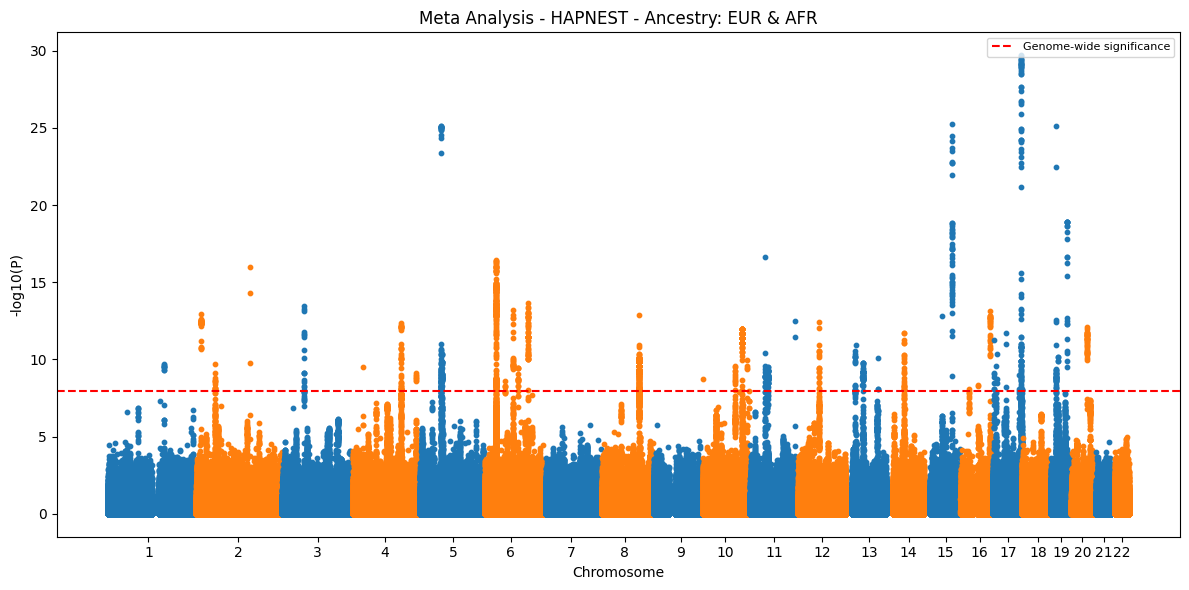

In [ ]:
# === LOAD DATA ===
# Lade die GWAS-Ergebnisse
gwas_file = "../data/meta_results.meta"
gwas_data = pd.read_csv(gwas_file, delim_whitespace=True)

# Entferne Zeilen mit fehlenden P-Werten
gwas_data = gwas_data.dropna(subset=["P"])
num_tests = gwas_data.shape[0]
bonferroni_threshold = 0.05 / num_tests

# === PREPARE DATA FOR MANHATTAN PLOT ===
# Erstelle eine Spalte für -log10(P)
gwas_data["-log10(P)"] = -np.log10(gwas_data["P"])

# Setze die Basisposition für jeden Chromosom (um die Punkte für den Plot anzupassen)
gwas_data["chromosome_position"] = 0
current_position = 0
positions = []

for chr_id in sorted(gwas_data["CHR"].unique()):
    chr_data = gwas_data[gwas_data["CHR"] == chr_id]
    gwas_data.loc[gwas_data["CHR"] == chr_id, "chromosome_position"] = chr_data["BP"] + current_position
    positions.append(current_position + chr_data["BP"].median())
    current_position += chr_data["BP"].max()

# === PLOT MANHATTAN PLOT ===
plt.figure(figsize=(12, 6))

# Farben für die Chromosomen (abwechselnd)
colors = ["#1f77b4", "#ff7f0e"]  # Blau, Orange
chromosomes = sorted(gwas_data["CHR"].unique())
for i, chr_id in enumerate(chromosomes):
    chr_data = gwas_data[gwas_data["CHR"] == chr_id]
    plt.scatter(
        chr_data["chromosome_position"],
        chr_data["-log10(P)"],
        color=colors[i % 2],
        s=10,
        #label=f"Chr {chr_id}" if i < 2 else None,
    )

# === ADD PLOT DETAILS ===
plt.axhline(y=-np.log10(bonferroni_threshold), color="red", linestyle="--", label="Genome-wide significance")
plt.xlabel("Chromosome")
plt.ylabel("-log10(P)")
plt.title("Meta Analysis - HAPNEST - Ancestry: EUR & AFR")
plt.xticks(positions, chromosomes)  # Setzt die Chromosomen als Achsenticks
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()

# === SHOW AND SAVE PLOT ===
plt.savefig("../data/results/manhattan_plot_meta.png", dpi=300)
plt.show()